# Cluster-Based Predictive Modeling (NBA Fantasy Points)

# Setup

### Imports

In [30]:
import os
import optuna
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from optuna.integration import OptunaSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Data into DataFrame

In [31]:
data_dir = '/teamspace/uploads/'
df = pd.read_parquet(f'{data_dir}player_stats_with_clusters_2022_2024.parquet')
print(f'Shape: {df.shape} \n{df.columns}')

Shape: (55968, 55) 
Index(['Date', 'Name', 'Team', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'GmSc', '+-', 'TeamAbbr', 'GameLink', 'Opponent', 'Home',
       'GameType', 'id', 'fpts_fanduel', 'Season', 'FG_2game_avg',
       'FGA_2game_avg', 'FG%_2game_avg', '3P_2game_avg', '3PA_2game_avg',
       '3P%_2game_avg', 'FT_2game_avg', 'FTA_2game_avg', 'FT%_2game_avg',
       'ORB_2game_avg', 'DRB_2game_avg', 'TRB_2game_avg', 'AST_2game_avg',
       'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 'PF_2game_avg',
       'PTS_2game_avg', 'GmSc_2game_avg', '+-_2game_avg',
       'fpts_fanduel_2game_avg', 'PTS_per_FGA_2game_avg', 'kmeans_cluster'],
      dtype='object')


In [32]:
df.head()

,Date,Name,Team,MP,FG,FGA,FG%,3P,3PA,3P%,...,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_2game_avg,GmSc_2game_avg,+-_2game_avg,fpts_fanduel_2game_avg,PTS_per_FGA_2game_avg,kmeans_cluster
4557,2022-10-18,noah vonleh,Boston Celtics,20.166667,1,2,0.5,0,0,0.0,...,0.0,0.0,1.0,2.5,1.0,-1.25,-2.0,2.40,0.666667,3
14351,2022-10-18,de'anthony melton,Philadelphia 76ers,20.550000,2,4,0.5,1,2,0.5,...,0.5,0.0,0.0,0.0,1.5,1.80,-9.0,6.45,0.600000,3
3461,2022-10-18,blake griffin,Boston Celtics,8.283333,0,2,0.0,0,1,0.0,...,1.5,0.0,2.0,4.5,6.0,5.95,-9.5,21.40,1.000000,2
9848,2022-10-18,danuel house jr.,Philadelphia 76ers,16.200000,0,2,0.0,0,1,0.0,...,1.0,0.0,1.0,1.0,1.5,1.60,-3.0,12.95,0.272727,3
12649,2022-10-18,donte divincenzo,Golden State Warriors,21.616667,3,6,0.5,1,2,0.5,...,1.0,0.0,0.5,1.0,11.0,8.40,-3.5,17.40,1.375000,0


### Correlation Matrix

In [33]:
df.isnull().sum().sum()

0

In [34]:
numeric_columns = [
  'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
  'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
  'PF', 'PTS', 'GmSc', '+-', 'fpts_fanduel', 'Home','FG_2game_avg', 'FGA_2game_avg', 
  'FG%_2game_avg', '3P_2game_avg','3PA_2game_avg', '3P%_2game_avg', 'FT_2game_avg', 
  'FTA_2game_avg','FT%_2game_avg', 'ORB_2game_avg', 'DRB_2game_avg', 'TRB_2game_avg', 
  'AST_2game_avg', 'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 
  'PF_2game_avg', 'PTS_2game_avg', 'GmSc_2game_avg', '+-_2game_avg',
  'fpts_fanduel_2game_avg', 'PTS_per_FGA_2game_avg', 'kmeans_cluster'
]

filtered_df = df[numeric_columns]
correlation_matrix = filtered_df.corr()

# Convert the correlation matrix to long format
correlation_matrix_long = correlation_matrix.reset_index().melt(id_vars='index')
correlation_matrix_long.columns = ['Feature1', 'Feature2', 'Correlation']

# Create an interactive heatmap using Plotly
fig = px.imshow(correlation_matrix,
                labels=dict(x="Features", y="Features", color="Correlation"),
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu_r',
                zmin=-1, zmax=1,
                aspect="auto")

# Customize the layout for better visibility
fig.update_layout(
    title="Correlation Heatmap of Selected Features with Target Variable",
    xaxis_title="Features",
    yaxis_title="Features",
    width=1400,
    height=1200
)

# Add hover information with the correlation value and feature names
fig.update_traces(hovertemplate='Correlation: %{z}<br>Feature 1: %{x}<br>Feature 2: %{y}')

# Show the interactive plot
fig.show()

# Data Preparation

In [6]:
selected_features = [
    'MP', 'FG_2game_avg', 'FGA_2game_avg', 'FG%_2game_avg', '3P_2game_avg', 
    '3PA_2game_avg', '3P%_2game_avg', 'FT_2game_avg', 'FTA_2game_avg', 
    'FT%_2game_avg', 'ORB_2game_avg', 'DRB_2game_avg', 'TRB_2game_avg', 
    'AST_2game_avg', 'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 
    'PF_2game_avg', 'PTS_2game_avg', 'GmSc_2game_avg', 'PTS_per_FGA_2game_avg'
]

X = df[selected_features]

In [7]:
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > .85)]
to_drop_filtered = [column for column in to_drop if column in X.columns]
X = X.drop(columns=to_drop_filtered)


X['Intercept'] = 1
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.drop(index=vif[vif['Feature'] == 'Intercept'].index)
print(vif)

                  Feature       VIF
0                      MP  1.907970
1            FG_2game_avg  4.630959
2           FG%_2game_avg  3.338451
3            3P_2game_avg  3.110839
4           3P%_2game_avg  2.232550
5            FT_2game_avg  3.041720
6           FT%_2game_avg  2.324977
7           ORB_2game_avg  1.522215
8           DRB_2game_avg  1.993458
9           AST_2game_avg  1.871749
10          STL_2game_avg  1.223233
11          BLK_2game_avg  1.254364
12          TOV_2game_avg  1.834293
13           PF_2game_avg  1.348198
14  PTS_per_FGA_2game_avg  2.892475


In [8]:
features = [
  'MP', 'FG_2game_avg', 'FG%_2game_avg', '3P_2game_avg', '3P%_2game_avg', 
  'FT_2game_avg', 'FT%_2game_avg', 'ORB_2game_avg', 'DRB_2game_avg', 
  'AST_2game_avg', 'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 
  'PF_2game_avg', 'PTS_per_FGA_2game_avg', 'kmeans_cluster'
]

X = df[features]
y = df['fpts_fanduel']
print(f'X: {X.shape}')
print(f'y: {y.shape}')
X.head()

X: (55968, 16)
y: (55968,)


,MP,FG_2game_avg,FG%_2game_avg,3P_2game_avg,3P%_2game_avg,FT_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_per_FGA_2game_avg,kmeans_cluster
4557,20.166667,0.5,0.2500,0.0,0.0000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.5,0.666667,3
14351,20.550000,0.5,0.1665,0.5,0.1665,0.0,0.0,0.0,1.0,1.5,0.5,0.0,0.0,0.0,0.600000,3
3461,8.283333,2.5,0.4715,0.0,0.0000,1.0,0.5,1.5,3.0,5.0,1.5,0.0,2.0,4.5,1.000000,2
9848,16.200000,0.5,0.0835,0.5,0.1000,0.0,0.0,0.0,1.0,5.5,1.0,0.0,1.0,1.0,0.272727,3
12649,21.616667,3.5,0.4165,3.0,0.4855,1.0,0.5,0.5,1.5,1.0,1.0,0.0,0.5,1.0,1.375000,0


Models to try:
- Linear Regression
- SGDRegressor
- KNeighborsRegressor
- Support Vector Regression
- XGBoost
- LightGBM
- CatBoost

# Data Split

## Data Splits by Cluster

In [9]:
clusters = X['kmeans_cluster'].unique()

data_splits = {}

for cluster in clusters:
  X_cluster = X[X['kmeans_cluster'] == cluster]
  y_cluster = y[X['kmeans_cluster'] == cluster]

  X_cluster = X_cluster.drop(columns=['kmeans_cluster'])

  X_temp, X_test, y_temp, y_test = train_test_split(X_cluster, y_cluster, test_size=0.1, random_state=42, shuffle=False)
  X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42, shuffle=False)


  data_splits[cluster] = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test
  }


In [10]:
# Iterating through the dictionary and printing the shapes
for cluster_label, splits in data_splits.items():
    print(f"Cluster {cluster_label}:")
    print(f"  X_train shape: {splits['X_train'].shape}")
    print(f"  X_val shape: {splits['X_val'].shape}")
    print(f"  X_test shape: {splits['X_test'].shape}")
    print(f"  y_train shape: {splits['y_train'].shape}")
    print(f"  y_val shape: {splits['y_val'].shape}")
    print(f"  y_test shape: {splits['y_test'].shape}")
    print(f"Total: {sum([splits['X_train'].shape[0], splits['X_val'].shape[0], splits['X_test'].shape[0]])}")
    print("-" * 50)

Cluster 3:
  X_train shape: (11143, 15)
  X_val shape: (1393, 15)
  X_test shape: (1393, 15)
  y_train shape: (11143,)
  y_val shape: (1393,)
  y_test shape: (1393,)
Total: 13929
--------------------------------------------------
Cluster 2:
  X_train shape: (14346, 15)
  X_val shape: (1794, 15)
  X_test shape: (1794, 15)
  y_train shape: (14346,)
  y_val shape: (1794,)
  y_test shape: (1794,)
Total: 17934
--------------------------------------------------
Cluster 0:
  X_train shape: (7385, 15)
  X_val shape: (924, 15)
  X_test shape: (924, 15)
  y_train shape: (7385,)
  y_val shape: (924,)
  y_test shape: (924,)
Total: 9233
--------------------------------------------------
Cluster 1:
  X_train shape: (11897, 15)
  X_val shape: (1487, 15)
  X_test shape: (1488, 15)
  y_train shape: (11897,)
  y_val shape: (1487,)
  y_test shape: (1488,)
Total: 14872
--------------------------------------------------


## Whole Dataset Split

In [11]:
X = X.drop(columns=['kmeans_cluster'])

In [12]:
print(X.shape)
X.head()

(55968, 15)


,MP,FG_2game_avg,FG%_2game_avg,3P_2game_avg,3P%_2game_avg,FT_2game_avg,FT%_2game_avg,ORB_2game_avg,DRB_2game_avg,AST_2game_avg,STL_2game_avg,BLK_2game_avg,TOV_2game_avg,PF_2game_avg,PTS_per_FGA_2game_avg
4557,20.166667,0.5,0.2500,0.0,0.0000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.5,0.666667
14351,20.550000,0.5,0.1665,0.5,0.1665,0.0,0.0,0.0,1.0,1.5,0.5,0.0,0.0,0.0,0.600000
3461,8.283333,2.5,0.4715,0.0,0.0000,1.0,0.5,1.5,3.0,5.0,1.5,0.0,2.0,4.5,1.000000
9848,16.200000,0.5,0.0835,0.5,0.1000,0.0,0.0,0.0,1.0,5.5,1.0,0.0,1.0,1.0,0.272727
12649,21.616667,3.5,0.4165,3.0,0.4855,1.0,0.5,0.5,1.5,1.0,1.0,0.0,0.5,1.0,1.375000


In [13]:
print(y.shape)
y.head()

(55968,)


4557     10.4
14351     8.0
3461      8.5
9848      8.7
12649    12.4
Name: fpts_fanduel, dtype: float64

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Total: {sum([X_train.shape[0], X_val.shape[0], X_test.shape[0]])}")
print("-" * 50)

X_train shape: (33580, 15)
X_val shape: (11194, 15)
X_test shape: (11194, 15)
y_train shape: (33580,)
y_val shape: (11194,)
y_test shape: (11194,)
Total: 55968
--------------------------------------------------


# Model Parameters

In [78]:
# Model Setup
models = {
    'LinearRegression': (LinearRegression(), {
      'fit_intercept': [False, True],
      }),

    'SGDRegressor': (SGDRegressor(), {
      'alpha': [0.0001, 0.001, 0.01, .1], 
      'max_iter': [2000, 3000, 5000], 
      'loss': ['squared_error', 'huber'],
      'penalty': ['l1', 'l2'],
      'fit_intercept': [False, True]
      }),

    'LinearSVR': (LinearSVR(), {
      'C': [0.01, 0.1, 1.0, 10.0], 
      'max_iter': [2000, 3000, 5000],
      'fit_intercept': [False, True]
      }),

    'XGBoost': (xgb.XGBRegressor(), {
      'n_estimators': [300, 500, 1000], 
      'learning_rate': [0.01, 0.1, 0.2, .3],
      'max_depth': [6, 8, 10],
      'min_child_weight': [5, 10, 100, 300],
      'subsample': [0.5],
      'seed': 42
      }),

    'LightGBM': (lgb.LGBMRegressor(), {
      'n_estimators': [50, 100, 200], 
      'learning_rate': [0.01, 0.1, 0.2]
      }),

    'CatBoost': (CatBoostRegressor(silent=True), {
      'iterations': [100, 200, 300], 
      'learning_rate': [0.01, 0.1, 0.2]
      })
}

# Model Training 1

In [31]:

metrics = {cluster: {} for cluster in data_splits.keys()}
def gridSearchCV(data_splits, models):
    for cluster_label, splits in data_splits.items():
        X_train, X_val, X_test = splits['X_train'], splits['X_val'], splits['X_test']
        y_train, y_val, y_test = splits['y_train'], splits['y_val'], splits['y_test']

        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        metrics[cluster_label] = {} 

        for model_name, (model, params) in models.items():
            print(f"Training {model_name} on Cluster {cluster_label}")

            pipeline = Pipeline([
                ('scaler', RobustScaler()),
                ('regressor', model)
            ])

            grid_search = GridSearchCV(pipeline, param_grid={'regressor__' + key: value for key, value in params.items()}, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

            grid_search.fit(X_train_scaled, y_train)

            # Best model and hyperparameters
            best_model = grid_search.best_estimator_
            print(f"  Best parameters for {model_name}: {grid_search.best_params_}")

            # Predict on validation set
            y_val_pred = best_model.predict(X_val_scaled)
            y_test_pred = best_model.predict(X_test_scaled)

            # Calculate metrics
            val_mae = mean_absolute_error(y_val, y_val_pred)
            val_r2 = r2_score(y_val, y_val_pred)
            val_mse = mean_squared_error(y_val, y_val_pred)
            test_mse = mean_squared_error(y_val, y_val_pred)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            test_r2 = r2_score(y_test, y_test_pred)

            print(f"  Validation MAE for {model_name}: {val_mae}")
            print(f"  Validation R2 for {model_name}: {val_r2}")
            print(f"  Test MAE for {model_name}: {test_mae}")
            print(f"  Test R2 for {model_name}: {test_r2}")

            # Store metrics
            metrics[cluster_label][model_name] = {
                'val_mae': val_mae,
                'val_mse': val_mse,
                'val_r2': val_r2,
                'test_mae': test_mae,
                'test_mse': test_mse,
                'test_r2': test_r2,
                'best_params': grid_search.best_params_
            }
    return metrics

## Evaluate

In [33]:
for metric in ['val_mae', 'val_r2', 'test_mae', 'test_r2']:
    plt.figure(figsize=(10, 6))
    for model in models.keys():
        values = [metrics[cluster_label][model][metric] for cluster_label in metrics.keys()]
        sns.lineplot(x=list(metrics.keys()), y=values, label=f'{model}', marker='o')

    plt.title(f'{metric.upper()} Comparison Across Clusters for Each Model')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric.upper())
    plt.xlabel('Clusters')
    plt.legend(title='Model')
    plt.show()

KeyError: 'LinearRegression'

<Figure size 1000x600 with 0 Axes>

In [23]:
data = []

# Iterate through the metrics dictionary and collect the data
for cluster_label, models_metrics in metrics.items():
    for model_name, scores in models_metrics.items():
        data.append({
            'Cluster': cluster_label,
            'Model': model_name,
            'Validation MAE': scores['val_mae'],
            'Validation R2': scores['val_r2'],
            'Test MAE': scores['test_mae'],
            'Test R2': scores['test_r2']
        })

# Create a DataFrame from the data
df_metrics = pd.DataFrame(data)

# Sort the DataFrame by 'Model' and 'Cluster'
df_metrics = df_metrics.sort_values(by=['Model', 'Cluster'])

# Group by 'Model' and display mini tables for each model
grouped = df_metrics.groupby('Model')

# Set the display format for floats
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Display mini tables in a compact, two-column format
import IPython.display as display
for model_name, group in grouped:
    print(f"Model: {model_name}")
    
    # Create a compact display
    compact_table = pd.concat([group[['Cluster', 'Validation MAE', 'Validation R2']].reset_index(drop=True),
                               group[['Test MAE', 'Test R2']].reset_index(drop=True)], axis=1)
    compact_table.columns = ['Cluster', 'Validation MAE', 'Validation R2', 'Test MAE', 'Test R2']
    
    display.display(compact_table)
    print("\n" + "-"*50 + "\n")


Model: CatBoost


,Cluster,Validation MAE,Validation R2,Test MAE,Test R2
0,0,4.5604,0.5713,4.6072,0.6221
1,1,7.0821,0.5270,7.1146,0.5490
2,2,7.8449,0.5160,7.8871,0.5624
3,3,4.2812,0.6547,4.2308,0.6144



--------------------------------------------------

Model: KNeighborsRegressor


,Cluster,Validation MAE,Validation R2,Test MAE,Test R2
0,0,5.5108,0.4272,5.6393,0.4582
1,1,7.8535,0.4413,8.0638,0.4236
2,2,8.6980,0.4234,8.6122,0.4687
3,3,5.3163,0.4996,5.2125,0.4470



--------------------------------------------------

Model: LightGBM


,Cluster,Validation MAE,Validation R2,Test MAE,Test R2
0,0,4.6779,0.5529,4.6518,0.6167
1,1,7.1238,0.5292,7.2256,0.5368
2,2,7.8871,0.5041,7.9226,0.5606
3,3,4.2926,0.6482,4.2536,0.6091



--------------------------------------------------

Model: LinearRegression


,Cluster,Validation MAE,Validation R2,Test MAE,Test R2
0,0,4.5434,0.5710,4.6589,0.6159
1,1,7.1147,0.5163,7.1216,0.5477
2,2,7.9809,0.5021,7.8823,0.5657
3,3,4.3167,0.6462,4.2178,0.6140



--------------------------------------------------

Model: LinearSVR


,Cluster,Validation MAE,Validation R2,Test MAE,Test R2
0,0,4.5279,0.5697,4.6302,0.6160
1,1,7.1030,0.5158,7.0963,0.5471
2,2,7.9561,0.5013,7.8792,0.5655
3,3,4.3091,0.6437,4.1791,0.6174



--------------------------------------------------

Model: SGDRegressor


,Cluster,Validation MAE,Validation R2,Test MAE,Test R2
0,0,4.5321,0.5712,4.6657,0.6145
1,1,7.1238,0.5152,7.1269,0.5480
2,2,7.9826,0.5022,7.8865,0.5645
3,3,4.3281,0.6443,4.2268,0.6144



--------------------------------------------------

Model: XGBoost


,Cluster,Validation MAE,Validation R2,Test MAE,Test R2
0,0,4.6596,0.5534,4.6475,0.6200
1,1,7.1893,0.5117,7.1896,0.5394
2,2,7.8602,0.5064,7.9766,0.5553
3,3,4.3089,0.6489,4.2960,0.5978



--------------------------------------------------



Dropping KNN Regression because R2 score over all clusters is below .5

Models to further evaluate:
- CatBoost
- LightGBM
- Linear Regression
- LinearSVR
- SGDRegressor
- XGBoost

# XGBoost

## Setup

In [35]:
xgb = xgb.XGBRegressor()

xgb_params = {
  'regressor__n_estimators': optuna.distributions.IntDistribution(1000, 2900),
  'regressor__learning_rate': optuna.distributions.FloatDistribution(0.02, 0.1),
  'regressor__max_depth': optuna.distributions.IntDistribution(6, 10),
  'regressor__min_child_weight': optuna.distributions.IntDistribution(100, 150),
  'regressor__subsample': optuna.distributions.FloatDistribution(0.5, 0.8),
  'regressor__seed': optuna.distributions.IntDistribution(42, 42),
  'regressor__device': optuna.distributions.CategoricalDistribution(['gpu']),
}

pipeline = Pipeline([
  ('scaler', MinMaxScaler()),
  ('regressor', xgb)
])

## Training by Cluster

In [29]:
results = {}

for cluster_label, splits in tqdm(data_splits.items(), desc="Clusters", unit='cluster'):
    print(f"Running OptunaSearchCV for Cluster {cluster_label}")

    X_train = splits['X_train']
    X_val = splits['X_val']
    X_test = splits['X_test']
    y_train = splits['y_train']
    y_val = splits['y_val']
    y_test = splits['y_test']

    grid_search = OptunaSearchCV(
        estimator=pipeline,
        param_distributions=xgb_params,
        cv=10,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1,
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_val_pred = best_model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Cluster {cluster_label} - Best Parameters: {best_params}")
    print(f"Cluster {cluster_label} - Validation MAE: {val_mae},\n" 
          f"Validation MSE: {val_mse},\n" 
          f"Validation R2: {val_r2}")
    
    results[cluster_label] = {
        'best_model': best_model,
        'best_params': best_params,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_r2': val_r2,
    }

print("GridSearchCV complete for all clusters.")
for clust_label, result in results.items():
    print(f"\nCluster {clust_label}:")
    print(f"  Best Parameters: {result['best_params']}")
    print(f"  Validation MAE: {result['val_mae']}")
    print(f"  Validation MSE: {result['val_mse']}")
    print(f"  Validation R2: {result['val_r2']}")

Clusters:   0%|          | 0/4 [00:00<?, ?cluster/s][I 2024-08-29 05:04:12,668] A new study created in memory with name: no-name-32fbfe7a-c839-4178-97af-ee8e3bfad4d6


Running OptunaSearchCV for Cluster 3


[I 2024-08-29 05:06:34,730] Trial 3 finished with value: -4.951972217072324 and parameters: {'regressor__n_estimators': 1025, 'regressor__learning_rate': 0.17571479712845547, 'regressor__max_depth': 13, 'regressor__min_child_weight': 157, 'regressor__subsample': 0.7465214837686578, 'regressor__seed': 42, 'regressor__device': 'gpu'}. Best is trial 3 with value: -4.951972217072324.
[I 2024-08-29 05:07:04,172] Trial 5 finished with value: -4.735052177191209 and parameters: {'regressor__n_estimators': 1516, 'regressor__learning_rate': 0.08533158279855667, 'regressor__max_depth': 15, 'regressor__min_child_weight': 175, 'regressor__subsample': 0.5964753104901303, 'regressor__seed': 42, 'regressor__device': 'gpu'}. Best is trial 5 with value: -4.735052177191209.
[I 2024-08-29 05:07:17,631] Trial 7 finished with value: -5.423376582795322 and parameters: {'regressor__n_estimators': 1504, 'regressor__learning_rate': 0.3685979941583404, 'regressor__max_depth': 8, 'regressor__min_child_weight': 13

Cluster 3 - Best Parameters: {'regressor__n_estimators': 1516, 'regressor__learning_rate': 0.08533158279855667, 'regressor__max_depth': 15, 'regressor__min_child_weight': 175, 'regressor__subsample': 0.5964753104901303, 'regressor__seed': 42, 'regressor__device': 'gpu'}
Cluster 3 - Validation MAE: 4.502721494098233,
Validation MSE: 40.30720825674157,
Validation R2: 0.6090969111734121
Running OptunaSearchCV for Cluster 2


[I 2024-08-29 05:14:17,641] Trial 2 finished with value: -8.465636658610887 and parameters: {'regressor__n_estimators': 1189, 'regressor__learning_rate': 0.09594034595916603, 'regressor__max_depth': 14, 'regressor__min_child_weight': 185, 'regressor__subsample': 0.9718630887382538, 'regressor__seed': 42, 'regressor__device': 'gpu'}. Best is trial 2 with value: -8.465636658610887.
[I 2024-08-29 05:14:24,357] Trial 6 finished with value: -8.875433634247013 and parameters: {'regressor__n_estimators': 1978, 'regressor__learning_rate': 0.16130035940760362, 'regressor__max_depth': 8, 'regressor__min_child_weight': 189, 'regressor__subsample': 0.6397730812528362, 'regressor__seed': 42, 'regressor__device': 'gpu'}. Best is trial 2 with value: -8.465636658610887.
[I 2024-08-29 05:14:45,885] Trial 7 finished with value: -8.737382827713038 and parameters: {'regressor__n_estimators': 1890, 'regressor__learning_rate': 0.11253735505461965, 'regressor__max_depth': 10, 'regressor__min_child_weight': 1

Cluster 2 - Best Parameters: {'regressor__n_estimators': 1189, 'regressor__learning_rate': 0.09594034595916603, 'regressor__max_depth': 14, 'regressor__min_child_weight': 185, 'regressor__subsample': 0.9718630887382538, 'regressor__seed': 42, 'regressor__device': 'gpu'}
Cluster 2 - Validation MAE: 8.452270851007672,
Validation MSE: 123.8661946274532,
Validation R2: 0.4323809774342935
Running OptunaSearchCV for Cluster 0


[I 2024-08-29 05:21:19,277] Trial 4 finished with value: -5.40414682965247 and parameters: {'regressor__n_estimators': 2814, 'regressor__learning_rate': 0.12642642635817794, 'regressor__max_depth': 9, 'regressor__min_child_weight': 200, 'regressor__subsample': 0.542778682002431, 'regressor__seed': 42, 'regressor__device': 'gpu'}. Best is trial 4 with value: -5.40414682965247.
[I 2024-08-29 05:22:14,687] Trial 7 finished with value: -5.789612312904909 and parameters: {'regressor__n_estimators': 2185, 'regressor__learning_rate': 0.31962572987214916, 'regressor__max_depth': 8, 'regressor__min_child_weight': 77, 'regressor__subsample': 0.9295882380562527, 'regressor__seed': 42, 'regressor__device': 'gpu'}. Best is trial 4 with value: -5.40414682965247.
[I 2024-08-29 05:22:17,072] Trial 1 finished with value: -6.341340793252044 and parameters: {'regressor__n_estimators': 2594, 'regressor__learning_rate': 0.42849987875082823, 'regressor__max_depth': 15, 'regressor__min_child_weight': 124, 'r

Cluster 0 - Best Parameters: {'regressor__n_estimators': 2465, 'regressor__learning_rate': 0.033369864411768355, 'regressor__max_depth': 11, 'regressor__min_child_weight': 66, 'regressor__subsample': 0.535847123264739, 'regressor__seed': 42, 'regressor__device': 'gpu'}
Cluster 0 - Validation MAE: 5.1109560856055385,
Validation MSE: 47.96970001929029,
Validation R2: 0.47897834589715205
Running OptunaSearchCV for Cluster 1


[I 2024-08-29 05:27:22,929] Trial 7 finished with value: -9.044491443357405 and parameters: {'regressor__n_estimators': 1463, 'regressor__learning_rate': 0.44656969337957403, 'regressor__max_depth': 9, 'regressor__min_child_weight': 199, 'regressor__subsample': 0.5034241430708333, 'regressor__seed': 42, 'regressor__device': 'gpu'}. Best is trial 7 with value: -9.044491443357405.
[I 2024-08-29 05:27:53,161] Trial 4 finished with value: -7.931135909313829 and parameters: {'regressor__n_estimators': 1005, 'regressor__learning_rate': 0.14373159323852347, 'regressor__max_depth': 15, 'regressor__min_child_weight': 153, 'regressor__subsample': 0.865186517317909, 'regressor__seed': 42, 'regressor__device': 'gpu'}. Best is trial 4 with value: -7.931135909313829.
[I 2024-08-29 05:28:15,452] Trial 3 finished with value: -8.60627746252945 and parameters: {'regressor__n_estimators': 1311, 'regressor__learning_rate': 0.4667104928801444, 'regressor__max_depth': 8, 'regressor__min_child_weight': 64, '

Cluster 1 - Best Parameters: {'regressor__n_estimators': 1015, 'regressor__learning_rate': 0.1023513350260751, 'regressor__max_depth': 16, 'regressor__min_child_weight': 113, 'regressor__subsample': 0.8841988242311543, 'regressor__seed': 42, 'regressor__device': 'gpu'}
Cluster 1 - Validation MAE: 7.822194974985233,
Validation MSE: 107.26915864875099,
Validation R2: 0.44143647434683364
GridSearchCV complete for all clusters.

Cluster 3:
  Best Parameters: {'regressor__n_estimators': 1516, 'regressor__learning_rate': 0.08533158279855667, 'regressor__max_depth': 15, 'regressor__min_child_weight': 175, 'regressor__subsample': 0.5964753104901303, 'regressor__seed': 42, 'regressor__device': 'gpu'}
  Validation MAE: 4.502721494098233
  Validation MSE: 40.30720825674157
  Validation R2: 0.6090969111734121

Cluster 2:
  Best Parameters: {'regressor__n_estimators': 1189, 'regressor__learning_rate': 0.09594034595916603, 'regressor__max_depth': 14, 'regressor__min_child_weight': 185, 'regressor__s

## Training on Whole Dataset - XGBoost

In [24]:
# Train XGBoost on whole dataset instead of clusters
grid_search = OptunaSearchCV(
    estimator=pipeline,
    param_distributions=xgb_params,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_val_pred = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation MAE: {val_mae},\n" 
      f"Validation MSE: {val_mse},\n" 
      f"Validation R2: {val_r2}")

results_whole = {
    'best_model': best_model,
    'best_params': best_params,
    'val_mae': val_mae,
    'val_mse': val_mse,
    'val_r2': val_r2,
}


[I 2024-08-29 09:47:08,095] A new study created in memory with name: no-name-b07cec15-5a7a-45a8-9d33-738808d2068a
[09:47:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.[09:47:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

[09:47:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
[09:47:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.[09:47:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.

[09:47:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
[09:47:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
[09:47:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
[09:47:17] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
[09:47:17] WARNING: 

Validation MAE: 6.350033402535548,
Validation MSE: 77.23347854138993,
Validation R2: 0.6822807833712967
Best Parameters: {'regressor__n_estimators': 1782, 'regressor__learning_rate': 0.022610716528266215, 'regressor__max_depth': 6, 'regressor__min_child_weight': 106, 'regressor__subsample': 0.686036456880101, 'regressor__seed': 42, 'regressor__device': 'gpu'}
Validation MAE: 6.350033402535548
Validation MSE: 77.23347854138993
Validation R2: 0.6822807833712967


In [25]:
print(f"Best Parameters: {results_whole['best_params']}")
print(f"Validation MAE: {results_whole['val_mae']}")
print(f"Validation MSE: {results_whole['val_mse']}")
print(f"Validation R2: {results_whole['val_r2']}")

Best Parameters: {'regressor__n_estimators': 1782, 'regressor__learning_rate': 0.022610716528266215, 'regressor__max_depth': 6, 'regressor__min_child_weight': 106, 'regressor__subsample': 0.686036456880101, 'regressor__seed': 42, 'regressor__device': 'gpu'}
Validation MAE: 6.350033402535548
Validation MSE: 77.23347854138993
Validation R2: 0.6822807833712967


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:10:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:10:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:10:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:10:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboo

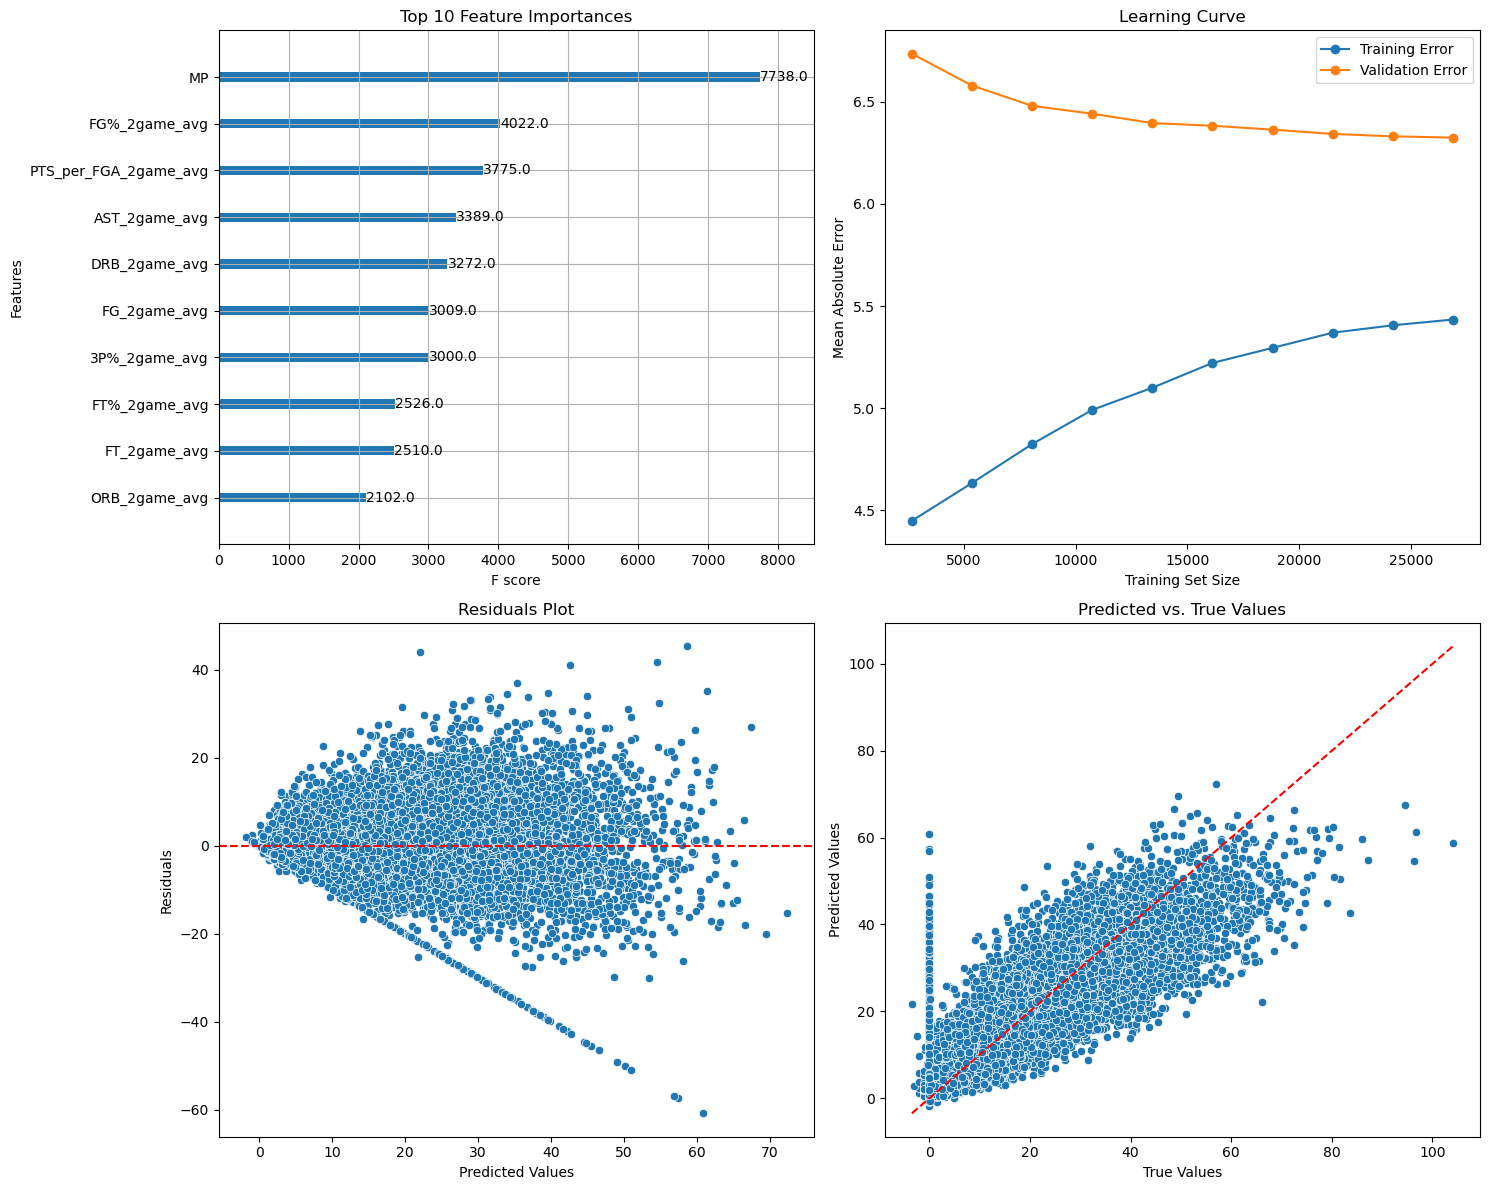

In [44]:
from xgboost import plot_importance

xgb_model = results_whole['best_model'].named_steps['regressor']

booster = xgb_model.get_booster()

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

feature_names = X_train.columns.to_list()
booster.feature_names = feature_names


# 1. Feature Importance Plot
plot_importance(booster, max_num_features=10, ax=axs[0, 0], importance_type='weight')
axs[0, 0].set_title('Top 10 Feature Importances')

# 2. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    results_whole['best_model'], X_train, y_train, cv=5, scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_mean = -np.mean(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
axs[0, 1].plot(train_sizes, train_mean, label='Training Error', marker='o')
axs[0, 1].plot(train_sizes, val_mean, label='Validation Error', marker='o')
axs[0, 1].set_title('Learning Curve')
axs[0, 1].set_xlabel('Training Set Size')
axs[0, 1].set_ylabel('Mean Absolute Error')
axs[0, 1].legend()

# 3. Residual Plot
y_val_pred = results_whole['best_model'].predict(X_val)
residuals = y_val - y_val_pred
sns.scatterplot(x=y_val_pred, y=residuals, ax=axs[1, 0])
axs[1, 0].axhline(0, color='r', linestyle='--')
axs[1, 0].set_title('Residuals Plot')
axs[1, 0].set_xlabel('Predicted Values')
axs[1, 0].set_ylabel('Residuals')

# 4. Prediction vs. True Values Plot
sns.scatterplot(x=y_val, y=y_val_pred, ax=axs[1, 1])
axs[1, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
axs[1, 1].set_title('Predicted vs. True Values')
axs[1, 1].set_xlabel('True Values')
axs[1, 1].set_ylabel('Predicted Values')

# Adjust layout
plt.tight_layout()
plt.show()


## Testing

In [ ]:
for cluster_label, result in results.items():
    print(f"Testing for Cluster {cluster_label}")

    splits = data_splits[cluster_label]
    X_test = splits['X_test']
    y_test = splits['y_test']

    best_model = result['best_model']
    y_test_pred = best_model.predict(X_test)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print test metrics
    print(f"Cluster {cluster_label} - 
          Test MAE: {test_mae} 
          Test MSE: {test_mse} 
          Test R2: {test_r2}")

    # Update the results dictionary with test metrics
    results[cluster_label].update({
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_r2': test_r2
    })